In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [30]:
epoch_num = 5

In [31]:
working_dir = os.getcwd()
print(working_dir)

# get the parent directory
parent_dir = os.path.dirname(working_dir)
print(parent_dir)

# get the data directory
data_dir = os.path.join(parent_dir, 'data/5epochs')
print(data_dir)

/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/FL_code
/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part
/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs


In [32]:
# find all the folders in the data directory
folders = os.listdir(data_dir)
print(folders)

net_folders = []
# get the folders that contain the network
for folder in folders:
    if folder.startswith('net'):
        net_folders.append(folder)
print(net_folders)

model_path = []
# open each folder and get the .pth files
for folder in net_folders:
    folder_path = os.path.join(data_dir, folder)
    # print(folder_path)
    files = os.listdir(folder_path)
    # print(files)
    for file in files:
        if file.endswith('net_state_dict_alexnet.pth'):
            file_path = os.path.join(folder_path, file)
            # print(file_path)
            # print('*************')
            model_path.append(file_path)

print(model_path)
            



['net2', 'combined_model_state_dict.pth', 'net1']
['net2', 'net1']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net2/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net1/net_state_dict_alexnet.pth']


In [33]:
import torch
from torch import nn
from d2l import torch as d2l

In [34]:
# Define your model architecture as provided
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

model_paths = model_path

# Load all model state dictionaries
state_dicts = [torch.load(path, map_location='cpu') for path in model_paths]
# print(state_dicts[1].keys())

# weights = [1.0 / len(state_dicts)] * len(state_dicts) 
weights = [0.5,0.5]

# Calculate the average of the parameters
avg_state_dict = {}
# for key in state_dicts[0]:
#     # Sum all parameters
#     sum_param = sum(state_dict[key] for state_dict in state_dicts)
#     # Take average
#     # avg_state_dict[key] = sum_param / len(state_dicts)
#     avg_state_dict[key] = sum_param
# # avg_state_dict = state_dicts[0]

for key in state_dicts[0]:
    weighted_sum_param = sum(weight * state_dict[key] for weight, state_dict in zip(weights, state_dicts))
    avg_state_dict[key] = weighted_sum_param

# Update the combined model with the averaged parameters
net.load_state_dict(avg_state_dict)

# Save the combined model
torch.save(net.state_dict(), os.path.join(data_dir, 'combined_model_state_dict.pth'))

In [35]:
# load the combined model
net.load_state_dict(torch.load(os.path.join(data_dir, 'combined_model_state_dict.pth')))

# load the test dataset
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# set the model to evaluation mode
test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
print(test_acc)

0.2759


### open the recorded acc data and the energy data

In [36]:
# find all the folders in the data directory
folders = os.listdir(data_dir)
print(folders)

data_folder = []
for name in folders:
    if name.startswith('net'):
        data_folder.append(name)
print(data_folder)

acc_data_files = []
train_acc_files = []
train_l_files = []
energy_data_files = []

# open each folder and get the .pth files
for folder in data_folder:
    folder_path = os.path.join(data_dir, folder)
    info_folder_path = os.path.join(folder_path, 'info')
    # print(folder_path)
    files = os.listdir(info_folder_path)
    print(files)
    for file in files:
        if file.startswith('acc_data'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            acc_data_files.append(file_path)
        elif file.startswith('train_acc'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            train_acc_files.append(file_path)
        elif file.startswith('train_l'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            train_l_files.append(file_path)
        elif file.startswith('energy_data_epoch'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            energy_data_files.append(file_path)
            

print(acc_data_files)
print(train_acc_files)
print(train_l_files)
print(energy_data_files)

['net2', 'combined_model_state_dict.pth', 'net1']
['net2', 'net1']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net2/info/acc_data.npy', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net1/info/acc_data.npy']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net2/info/train_acc.npy', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net1/info/train_acc.npy']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net2/info/train_l.npy', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/5epochs/net1/info/train_l.npy']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_

#### acc_data_matrix

In [37]:
acc_data_matrix = np.zeros((len(acc_data_files), epoch_num))
for acc_data_file in acc_data_files:
    acc_data = np.load(acc_data_file, allow_pickle=True)
    # print(acc_data)
    acc_data_matrix[acc_data_files.index(acc_data_file), :] = acc_data
print(acc_data_matrix)  

[[0.703  0.7971 0.8131 0.8426 0.8539]
 [0.737  0.7963 0.8225 0.8475 0.85  ]]


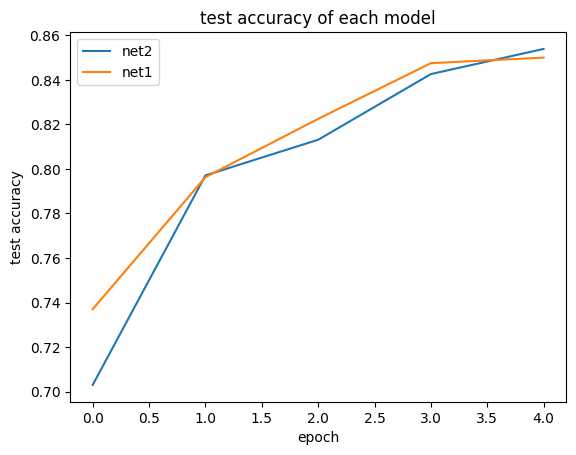

In [38]:
# plot each model's test accuracy in the same figure
plt.figure()
for i in range(acc_data_matrix.shape[0]):
    plt.plot(acc_data_matrix[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('test accuracy of each model')
# plt.savefig(os.path.join(data_dir, 'test_acc.png'))
plt.show()

#### train_acc_matrix

In [39]:
train_acc_matrix = np.zeros((len(train_acc_files), epoch_num, 469))
for train_acc_file in train_acc_files:
    train_acc = np.load(train_acc_file, allow_pickle=True)
    print(train_acc.shape)
    train_acc_matrix[train_acc_files.index(train_acc_file),:, :] = train_acc
print(train_acc_matrix)

(5, 469)
(5, 469)
[[[0.109375   0.09375    0.11458333 ... 0.52121253 0.52155115 0.52178333]
  [0.671875   0.703125   0.71354167 ... 0.75876606 0.75876402 0.75875   ]
  [0.7890625  0.796875   0.7890625  ... 0.80022082 0.80024706 0.80023333]
  [0.75       0.76953125 0.796875   ... 0.8245617  0.82450254 0.82456667]
  [0.859375   0.87109375 0.8828125  ... 0.84180942 0.8417301  0.84176667]]

 [[0.09375    0.08984375 0.08072917 ... 0.47393603 0.47447583 0.47478333]
  [0.7109375  0.7109375  0.703125   ... 0.75391461 0.7540231  0.75406667]
  [0.7890625  0.79296875 0.8046875  ... 0.7989996  0.79897837 0.79906667]
  [0.859375   0.8515625  0.84114583 ... 0.82491301 0.8248364  0.82481667]
  [0.875      0.84765625 0.859375   ... 0.84251204 0.84251469 0.84245   ]]]


In [40]:
train_acc_avg = np.mean(train_acc_matrix, axis=2)
print(train_acc_avg)
    

[[0.33480417 0.74219695 0.79626315 0.81762219 0.83805378]
 [0.28248814 0.73372921 0.78766651 0.8223802  0.84206495]]


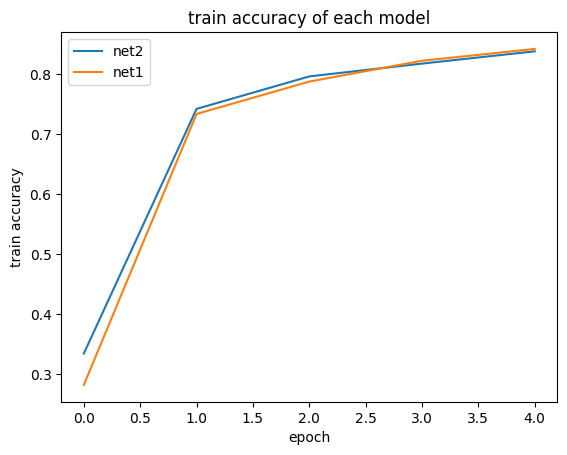

In [41]:
# plot each model's train accuracy in the same figure
plt.figure()
for i in range(train_acc_avg.shape[0]):
    plt.plot(train_acc_avg[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train accuracy')
plt.title('train accuracy of each model')
# plt.savefig(os.path.join(data_dir, 'train_acc.png'))
plt.show()

#### train_l_matrix

In [42]:
train_l_matrix = np.zeros((len(train_l_files), epoch_num, 469))
for train_l_file in train_l_files:
    train_l = np.load(train_l_file, allow_pickle=True)
    print(train_l.shape)
    train_l_matrix[train_l_files.index(train_l_file),:, :] = train_l
print(train_l_matrix)

(5, 469)
(5, 469)
[[[2.30232596 2.3038975  2.30295062 ... 1.30536421 1.30412935 1.30343667]
  [0.79089785 0.74503702 0.70804141 ... 0.64746332 0.64748166 0.64735584]
  [0.5227443  0.56123322 0.56093681 ... 0.53698368 0.53701927 0.53716834]
  [0.59314436 0.58707157 0.52663706 ... 0.47176913 0.47188841 0.47178172]
  [0.37957388 0.33992103 0.31664229 ... 0.42849347 0.4289251  0.42872913]]

 [[2.29686093 2.30237687 2.30350868 ... 1.43429268 1.43304125 1.4321678 ]
  [0.80907726 0.8136251  0.79982956 ... 0.65372013 0.65355618 0.65354616]
  [0.5980581  0.59405941 0.56490091 ... 0.53739076 0.53743836 0.53711824]
  [0.36059207 0.42765284 0.44565035 ... 0.47152919 0.47166368 0.47178861]
  [0.49376228 0.48703894 0.43114803 ... 0.42786415 0.42773793 0.42787651]]]


In [43]:
train_l_avg = np.mean(train_l_matrix, axis=2)
print(train_l_avg)

[[1.81619933 0.68466455 0.54980506 0.48387224 0.4355927 ]
 [1.94417307 0.70264327 0.56332077 0.47857562 0.43484848]]


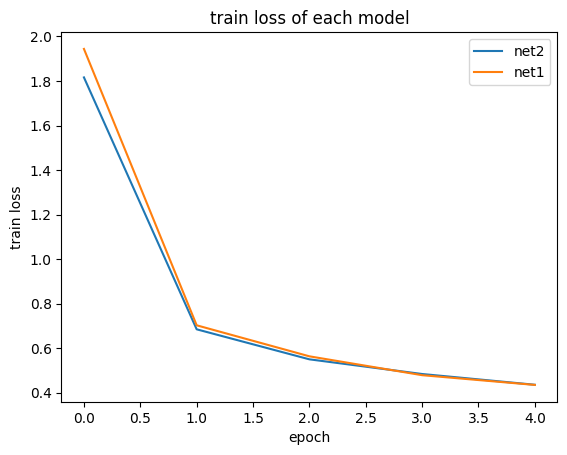

In [44]:
# plot each model's train loss in the same figure
plt.figure()
for i in range(train_l_avg.shape[0]):
    plt.plot(train_l_avg[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('train loss of each model')
# plt.savefig(os.path.join(data_dir, 'train_loss.png'))
plt.show()

#### energy_data

In [45]:
energy_data_matrix = np.zeros((len(energy_data_files), epoch_num, 1), dtype=object)
for energy_data_file in energy_data_files:
    energy_data = np.load(energy_data_file, allow_pickle=True)
    # print(energy_data)
    energy_data_matrix[energy_data_files.index(energy_data_file),:, :] = energy_data
print(energy_data_matrix)

[[[list([8281, 11180, 9732, 10596, 10686, 9630, 10750, 12549, 11445, 11236, 10344, 9507, 9496, 9974, 10542, 12082, 15998, 20666, 10318, 10787, 9850, 8642, 9302, 9424, 9022, 9358, 10273, 9635, 8834, 9005, 10742, 10987, 9209, 8628, 9152, 9062, 8838, 8906, 9507, 9286, 8298, 9017, 10990, 9129, 8637, 9271, 11290, 9517, 10648, 9434, 11711, 9494, 10662, 9869, 9500, 9921, 8983, 9537, 10643, 14616, 13601, 11552, 11494, 9447, 12132, 9946, 10549, 10832, 9948, 10070, 10958, 9744, 9386, 8579, 8131, 8704, 8690, 8559, 10159, 9095, 8884, 8652, 8484, 8337, 8268, 8890, 8587, 8577, 7821, 8991, 9150, 8547, 8368, 9592, 14037, 11486, 12003, 9962, 10294, 10060, 16336, 11039, 11850, 12054, 9234, 8978, 9820, 14088, 12627, 9788, 10129, 11550, 9751, 10299, 10241, 10673, 9933, 11727, 15524, 14784, 11776, 9556, 9552, 15164, 11402, 10914, 9494, 10382, 10835, 10803, 9251, 9135, 9320, 8955, 8756, 8278, 8392, 10763, 9114, 9612, 8366, 8852, 9135, 8869, 8578, 8131, 9049, 13274, 10811, 9952, 10630, 8290, 9349, 10010, 910

In [46]:
energy_data_avg = np.zeros((energy_data_matrix.shape[0], energy_data_matrix.shape[1]))
energy_data_total = np.zeros((energy_data_matrix.shape[0], energy_data_matrix.shape[1]))
for i in range(energy_data_matrix.shape[0]):
    devicei_energy = energy_data_matrix[i, :, :]
    for j in range(devicei_energy.shape[0]):
        devicei_energy_epochi = np.array(devicei_energy[j, :][0])
        # print(devicei_energy_epochi)
        devicei_energy_epochi_mean = np.mean(devicei_energy_epochi)  
        devicei_energy_epochi_total = np.sum(devicei_energy_epochi)  
        # print(devicei_energy_epochi_mean)
        energy_data_avg[i, j] = devicei_energy_epochi_mean  
        energy_data_total[i, j] = devicei_energy_epochi_total
print(energy_data_avg)
print(energy_data_total)
        
    

[[10198.29648241 10037.36453202  9867.94074074  9835.94840295
  10803.48157248]
 [10040.44764398 10110.65963061 10123.56200528 10204.0183727
  10194.6373057 ]]
[[4058922. 4075170. 3996516. 4003231. 4397017.]
 [3835451. 3831940. 3836830. 3887731. 3935130.]]


In [47]:
# calculate the total energy consumption of each model
energy_data_total_sum = np.sum(energy_data_total, axis=1)
print(energy_data_total_sum)

[20530856. 19327082.]


In [48]:
# calculate the total energy consumption of all models
energy_data_total_sum_all = np.sum(energy_data_total_sum)
print(energy_data_total_sum_all)

39857938.0


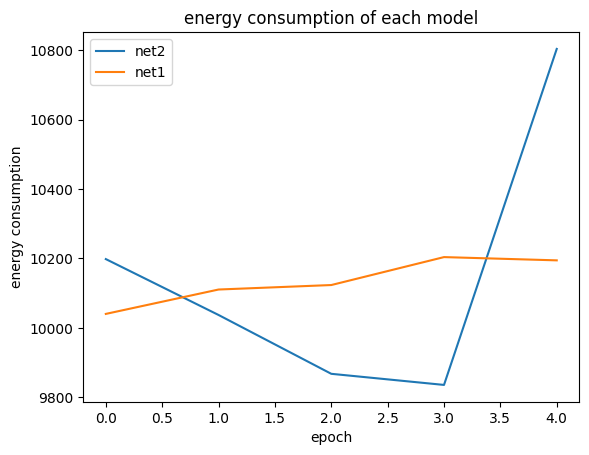

In [49]:
# plot each model's energy consumption in the same figure
plt.figure()
for i in range(energy_data_avg.shape[0]):
    plt.plot(energy_data_avg[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('energy consumption')
plt.title('energy consumption of each model')
# plt.savefig(os.path.join(data_dir, 'energy_consumption.png'))
plt.show()